In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
from typing import Any, Literal
from math import ceil
import time
import datetime
import random

from dataclasses import dataclass

import requests
from requests import Response
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

from tqdm import tqdm
import webscraping_lib

from omegaconf import MISSING, OmegaConf, DictConfig
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.core.config_store import ConfigStore


In [8]:
%config InlineBackend.figure_format = 'retina'

facecolor = '#2F4558'
plt.rcParams['figure.facecolor'] = facecolor
plt.rcParams['axes.facecolor'] = facecolor
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

font_size = 22
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 6
plt.rcParams['ytick.labelsize'] = font_size - 6
plt.rcParams['legend.fontsize'] = font_size - 6

plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.family'] = 'Arial'

In [9]:
@dataclass
class Config:
    web: webscraping_lib.CompaniesMarketCapConfig = MISSING
    data: webscraping_lib.DataConfig = MISSING
    debug: bool = False
    project_name: str = ""
    outdir: str = ""


cs: ConfigStore = ConfigStore.instance()
cs.store(name="base_config", node=Config)

# webscraping_lib registers its configs
# in webscraping_lib/web webscraping_lib/data
webscraping_lib.register_configs()


In [10]:
with initialize(version_base=None, config_path="conf"):
    CFG: DictConfig = compose(config_name="config")
    print(CFG)


{'web': {'user_agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:92.0) Gecko/20100101 Firefox/92.0', 'parser': 'lxml', 'companies_url': 'https://companiesmarketcap.com', 'ticker_url': 'https://finance.yahoo.com/quote/', 'page_param': '/?page=', 'companies_by': [{'by': 'marketcap', 'category': ''}, {'by': 'profit', 'category': '/most-profitable-companies'}, {'by': 'revenue', 'category': '/largest-companies-by-revenue'}, {'by': 'employees', 'category': '/largest-companies-by-number-of-employees'}], 'output_filename': '_companies_', 'max_companies': 10, 'start_from': 1}, 'data': {'data_dir': 'data/'}, 'debug': True, 'project_name': 'titan', 'outdir': '${hydra.runtime.output_dir}'}


In [11]:
df = pd.read_csv("clean.csv", index_col=0)
df.head()
 

company   ticker  marketcap    price daily change    country  \
0              Apple     AAPL   $2.066 T  $129.93        0.25%        USA   
1       Saudi Aramco  2222.SR   $1.883 T    $8.56        0.77%  S. Arabia   
2          Microsoft     MSFT   $1.787 T  $239.82        0.49%        USA   
3  Alphabet (Google)     GOOG   $1.145 T   $88.73        0.25%        USA   
4             Amazon     AMZN  $856.94 B   $84.00        0.21%        USA   

      profit    revenue  employees  
0  $122.03 B  $394.32 B   164000.0  
1  $303.30 B  $552.25 B    70000.0  
2   $84.76 B  $203.07 B   221000.0  
3   $78.96 B  $282.11 B   186779.0  
4   $12.11 B  $502.19 B  1544000.0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6384 entries, 0 to 6383
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       6384 non-null   object 
 1   ticker        6383 non-null   object 
 2   marketcap     6384 non-null   object 
 3   price         6384 non-null   object 
 4   daily change  6384 non-null   object 
 5   country       6384 non-null   object 
 6   profit        6366 non-null   object 
 7   revenue       6189 non-null   object 
 8   employees     5849 non-null   float64
dtypes: float64(1), object(8)
memory usage: 498.8+ KB


In [13]:
def remove_extra_chars(x):
    x = x.replace("$", "")
    x = x.replace("%", "")
    x = x.replace(",", ".")
    return x


def string_to_float(x):
    if len(x) <= 1:
        return "".join(x)
    if x[1] == "T":
        mul = 1e12
    elif x[1] == "B":
        mul = 1e9
    elif x[1] == "M":
        mul = 1e6
    else:
        return "".join(x)

    return float(x[0]) * mul


In [14]:
df = df.applymap(lambda x: remove_extra_chars(x) if isinstance(x, str) else x)
df

company   ticker marketcap   price daily change    country  \
0                    Apple     AAPL   2.066 T  129.93         0.25        USA   
1             Saudi Aramco  2222.SR   1.883 T    8.56         0.77  S. Arabia   
2                Microsoft     MSFT   1.787 T  239.82         0.49        USA   
3        Alphabet (Google)     GOOG   1.145 T   88.73         0.25        USA   
4                   Amazon     AMZN  856.94 B   84.00         0.21        USA   
...                    ...      ...       ...     ...          ...        ...   
6379               Biocept     BIOC    9.04 M    0.53         7.83        USA   
6380          Evoke Pharma     EVOK    8.95 M    2.68         6.35        USA   
6381                Farmmi     FAMI    8.93 M    0.40         4.37      China   
6382               Tricida     TCDA    8.87 M    0.15        11.87        USA   
6383  Great Panther Mining      GPL     8.8 M    0.19         0.00     Canada   

        profit   revenue  employees  
0     122.03 B  394.32 B   164000.0  
1     303.30 B  552.25 B    70000.0  
2      84.76 B  203.07 B   221000.0  
3      78.96 B  282.11 B   186779.0  
4      12.11 B  502.19 B  1544000.0  
...        ...       ...        ...  
6379  -17.47 M   50.11 M      177.0  
6380    -7.6 M    2.07 M        4.0  
6381     2.5 M   39.28 M       67.0  
6382   -0.14 B       NaN       57.0  
6383  -42.21 M    0.18 B        NaN  

[6384 rows x 9 columns]

In [15]:
df = df.applymap(lambda x: string_to_float(x.split()) if isinstance(x, str) else x)
df


company   ticker     marketcap   price daily change  \
0                  Apple     AAPL  2.066000e+12  129.93         0.25   
1            SaudiAramco  2222.SR  1.883000e+12    8.56         0.77   
2              Microsoft     MSFT  1.787000e+12  239.82         0.49   
3       Alphabet(Google)     GOOG  1.145000e+12   88.73         0.25   
4                 Amazon     AMZN  8.569400e+11   84.00         0.21   
...                  ...      ...           ...     ...          ...   
6379             Biocept     BIOC  9.040000e+06    0.53         7.83   
6380         EvokePharma     EVOK  8.950000e+06    2.68         6.35   
6381              Farmmi     FAMI  8.930000e+06    0.40         4.37   
6382             Tricida     TCDA  8.870000e+06    0.15        11.87   
6383  GreatPantherMining      GPL  8.800000e+06    0.19         0.00   

       country        profit       revenue  employees  
0          USA  1.220300e+11  3.943200e+11   164000.0  
1     S.Arabia  3.033000e+11  5.522500e+11    70000.0  
2          USA  8.476000e+10  2.030700e+11   221000.0  
3          USA  7.896000e+10  2.821100e+11   186779.0  
4          USA  1.211000e+10  5.021900e+11  1544000.0  
...        ...           ...           ...        ...  
6379       USA -1.747000e+07  5.011000e+07      177.0  
6380       USA -7.600000e+06  2.070000e+06        4.0  
6381     China  2.500000e+06  3.928000e+07       67.0  
6382       USA -1.400000e+08           NaN       57.0  
6383    Canada -4.221000e+07  1.800000e+08        NaN  

[6384 rows x 9 columns]

In [16]:
df["daily change"] = df["daily change"].astype(float)
df["price"] = df["price"].astype(float)
df.rename(columns={"daily change": "daily change (%)"}, inplace=True)


In [17]:
df

company   ticker     marketcap   price  daily change (%)  \
0                  Apple     AAPL  2.066000e+12  129.93              0.25   
1            SaudiAramco  2222.SR  1.883000e+12    8.56              0.77   
2              Microsoft     MSFT  1.787000e+12  239.82              0.49   
3       Alphabet(Google)     GOOG  1.145000e+12   88.73              0.25   
4                 Amazon     AMZN  8.569400e+11   84.00              0.21   
...                  ...      ...           ...     ...               ...   
6379             Biocept     BIOC  9.040000e+06    0.53              7.83   
6380         EvokePharma     EVOK  8.950000e+06    2.68              6.35   
6381              Farmmi     FAMI  8.930000e+06    0.40              4.37   
6382             Tricida     TCDA  8.870000e+06    0.15             11.87   
6383  GreatPantherMining      GPL  8.800000e+06    0.19              0.00   

       country        profit       revenue  employees  
0          USA  1.220300e+11  3.943200e+11   164000.0  
1     S.Arabia  3.033000e+11  5.522500e+11    70000.0  
2          USA  8.476000e+10  2.030700e+11   221000.0  
3          USA  7.896000e+10  2.821100e+11   186779.0  
4          USA  1.211000e+10  5.021900e+11  1544000.0  
...        ...           ...           ...        ...  
6379       USA -1.747000e+07  5.011000e+07      177.0  
6380       USA -7.600000e+06  2.070000e+06        4.0  
6381     China  2.500000e+06  3.928000e+07       67.0  
6382       USA -1.400000e+08           NaN       57.0  
6383    Canada -4.221000e+07  1.800000e+08        NaN  

[6384 rows x 9 columns]

In [18]:
df.to_csv("merged.csv", index=None)

In [19]:
no_countries = df["country"].nunique()
print(f"There are {no_countries} countries in the dataset.")


There are 69 countries in the dataset.


In [20]:
df_countries = pd.DataFrame({"country": df["country"].unique()})

fig = px.choropleth(
    df_countries,
    locations="country",
    color_discrete_sequence=np.full(no_countries, "lightcoral"),
    locationmode="country names",
    fitbounds="locations",
)

fig.update_layout(
    width=800,
    plot_bgcolor=facecolor,
    paper_bgcolor=facecolor,
    geo=dict(
        bgcolor=facecolor,
        landcolor="#375167",
        showlakes=False,
        showocean=True,
        oceancolor=facecolor,
    ),
    title={
        "text": "Countries With At Least One Company In The Dataset",
        "x": 0.5,
        "xanchor": "center",
        "y": 0.95,
        "font": {"color": "white", "size": 27, "family": "Arial"},
    },
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
)

fig.update_traces(showlegend=False)
fig.update_geos(resolution=50, visible=True)

fig.show(renderer="svg")


## Top 20 Countries With The Most Companies

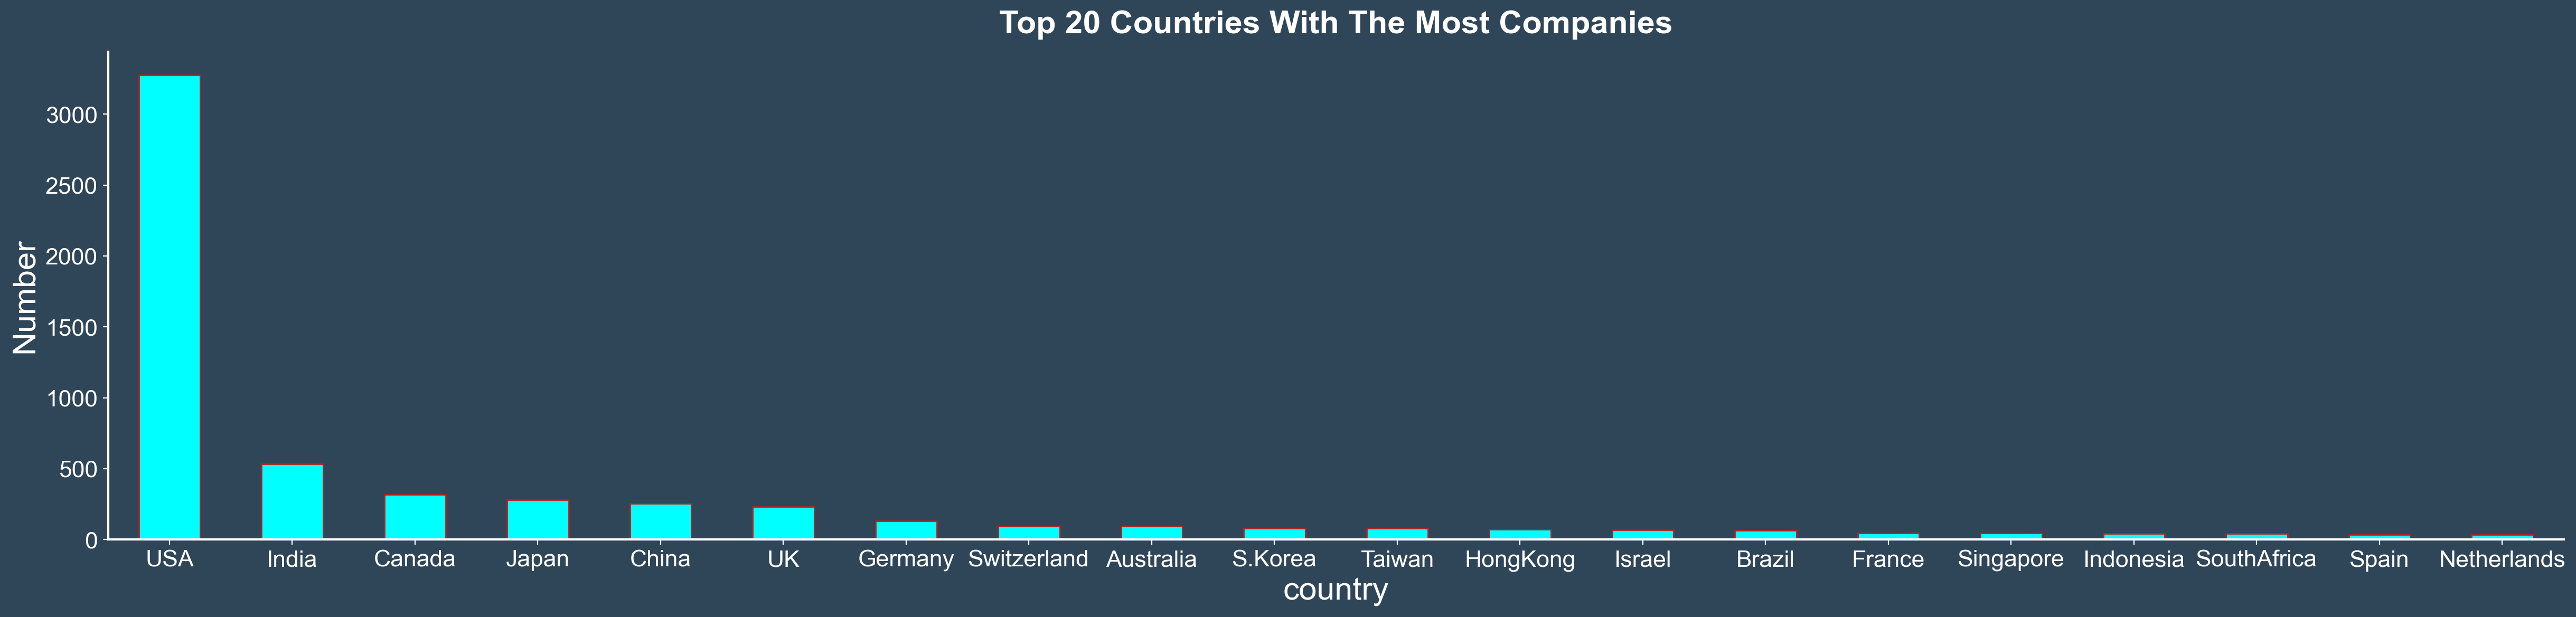

In [21]:
fig, ax = plt.subplots(figsize=(30, 6), facecolor=facecolor)

df["country"].value_counts().head(20).plot(
    kind="bar", color="cyan", edgecolor="firebrick", ax=ax
)

ax.set_title("Top 20 Countries With The Most Companies", y=1.02)
ax.set(xlabel="country", ylabel="Number")
ax.tick_params(axis="x", labelrotation=0)


In [22]:
df_total_mc = df.groupby("country")["marketcap"].sum().to_frame()
df_total_mc.sort_values(by="marketcap", ascending=False, inplace=True)


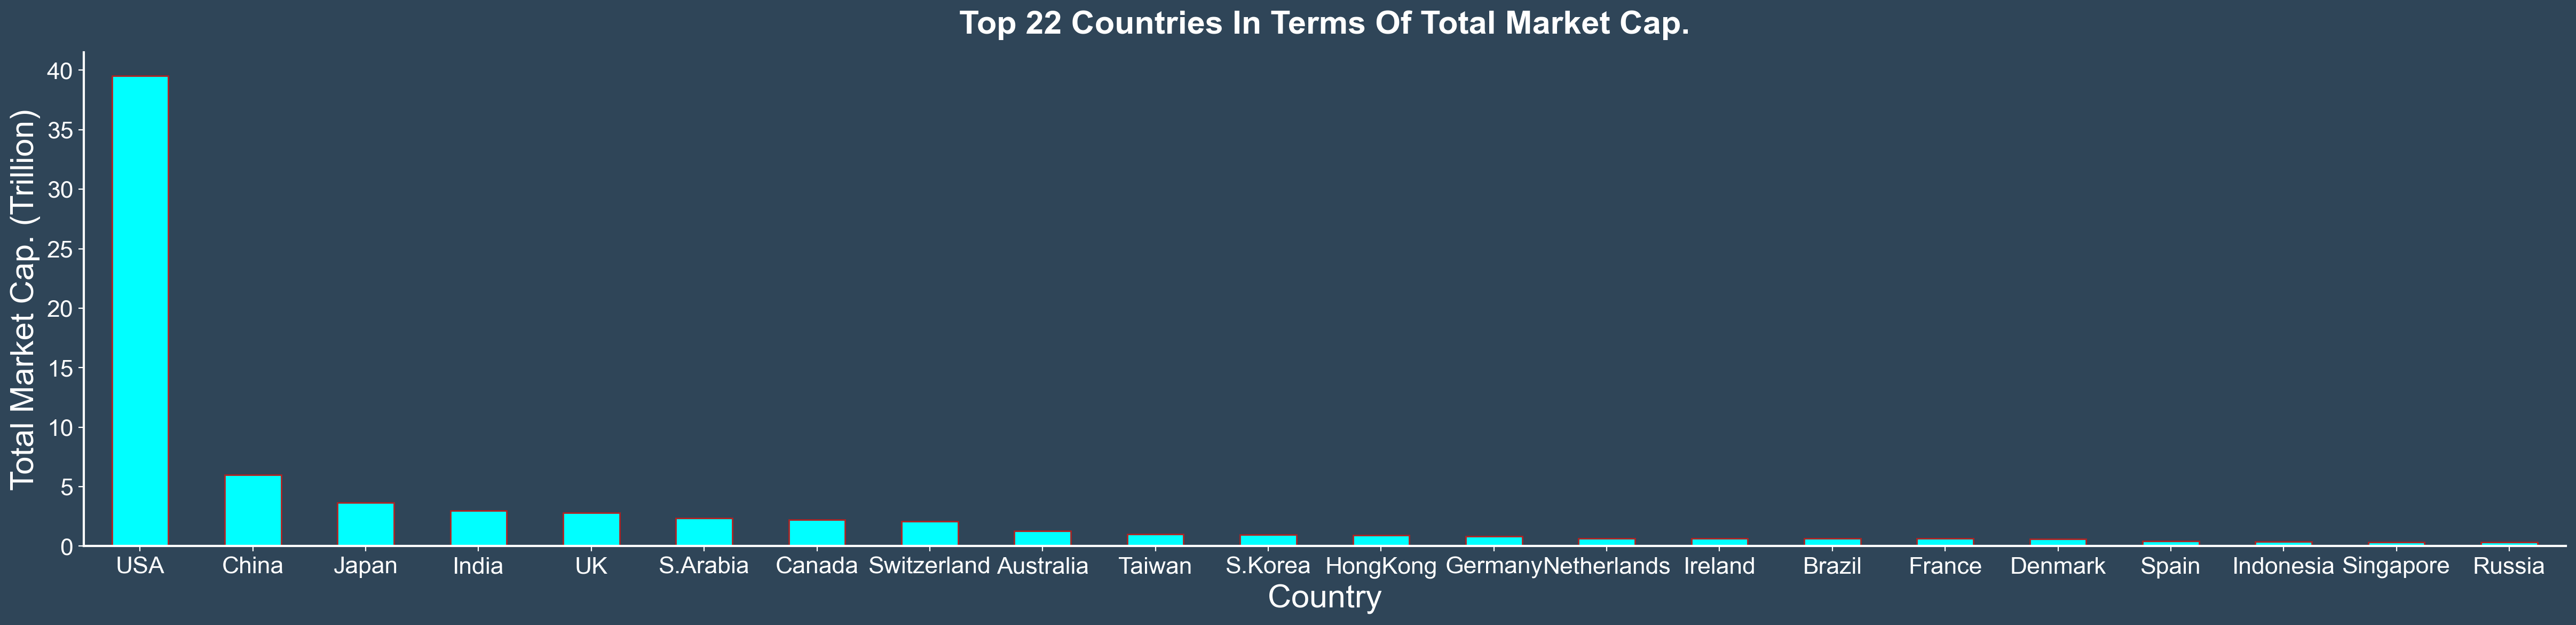

In [23]:
fig, ax = plt.subplots(figsize=(30, 6), facecolor=facecolor)

df_total_mc.head(22).plot(kind="bar", color="cyan", edgecolor="firebrick", ax=ax)

ax.set_title("Top 22 Countries In Terms Of Total Market Cap.", y=1.02)
ax.set(xlabel="Country", ylabel="Total Market Cap. (Trillion)")

scale_y = 1e12
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.tick_params(axis="x", labelrotation=0)
ax.get_legend().remove()


In [24]:
usa_comparison = pd.DataFrame(
    {"USA": df_total_mc.iloc[0], "Rest of the World": df_total_mc.iloc[1:].sum()}
).T


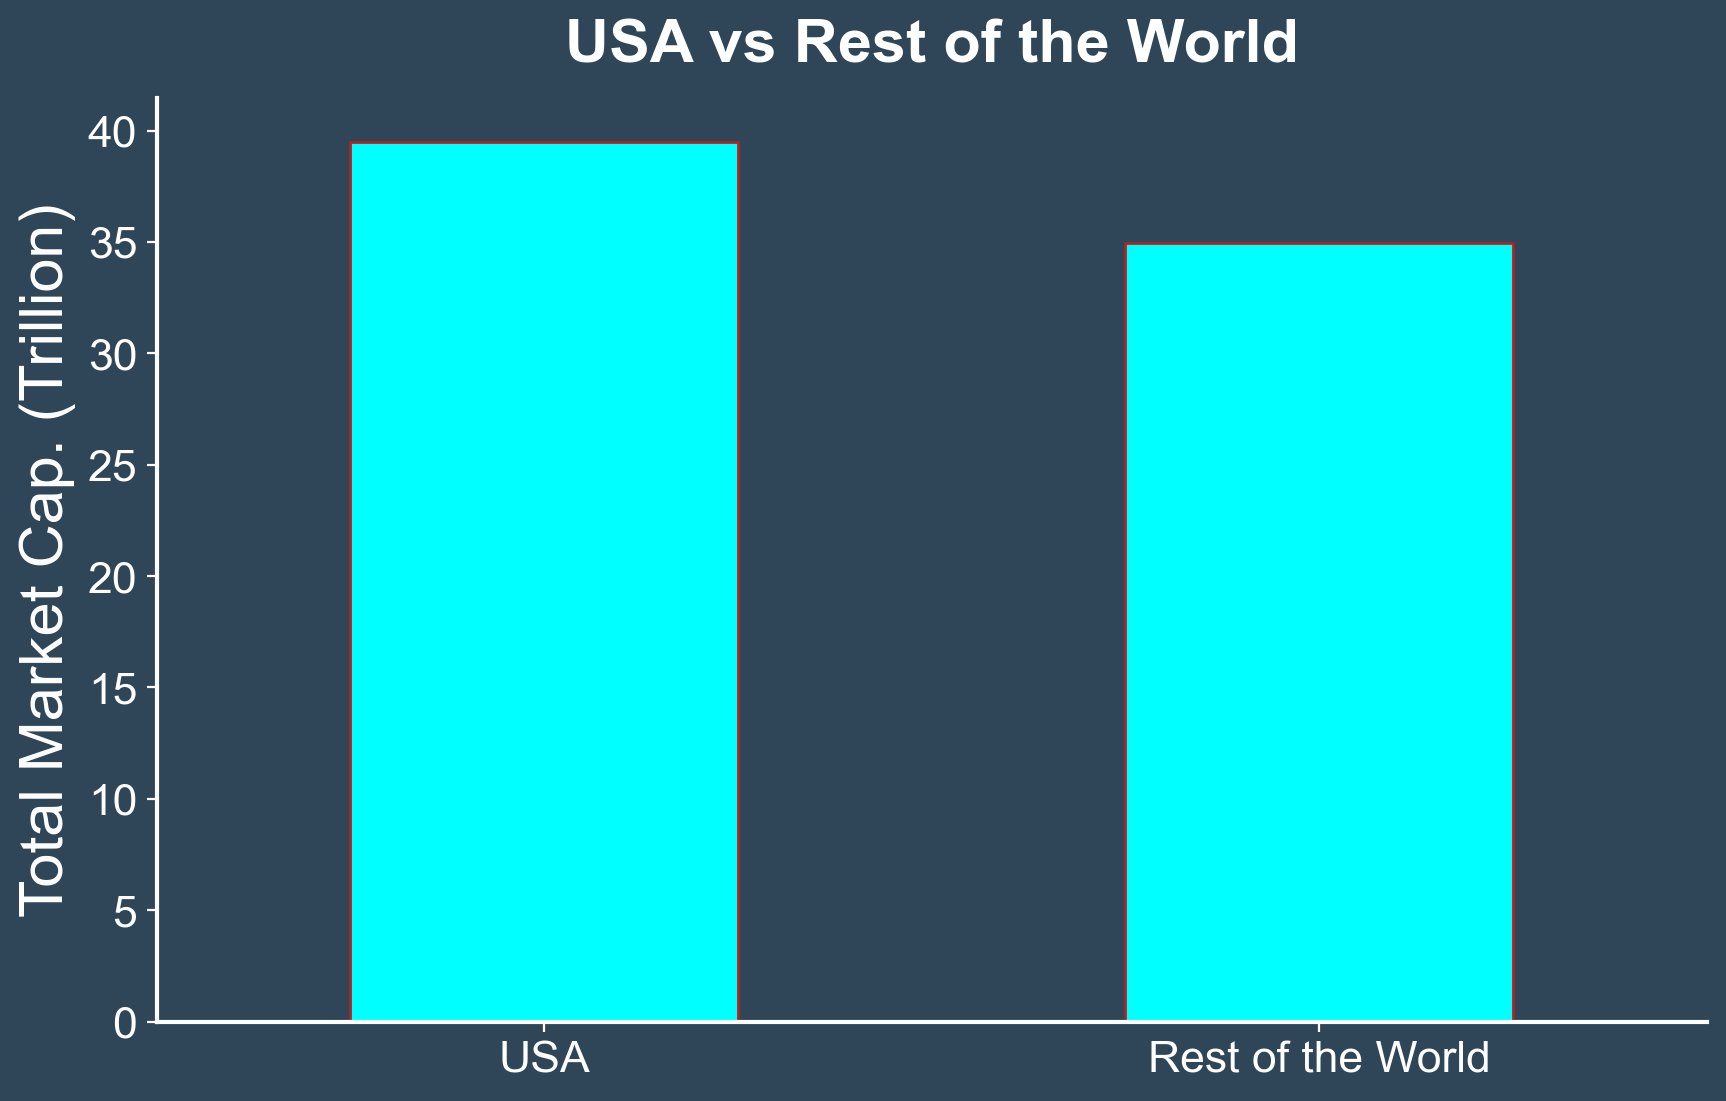

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor=facecolor)

usa_comparison.plot(kind="bar", color="cyan", edgecolor="firebrick", ax=ax)

ax.set_title("USA vs Rest of the World", y=1.02)
ax.set(ylabel="Total Market Cap. (Trillion)")

scale_y = 1e12
ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / scale_y))
ax.yaxis.set_major_formatter(ticks_y)

ax.tick_params(axis="x", labelrotation=0)
ax.get_legend().remove()


In [27]:
df["profit_by_emp"] = df["profit"] / df["employees"]


In [55]:
df_profit_by_emp = df.groupby("company")["profit_by_emp"].sum().to_frame().sort_values(by="profit_by_emp", ascending=False, inplace=False)

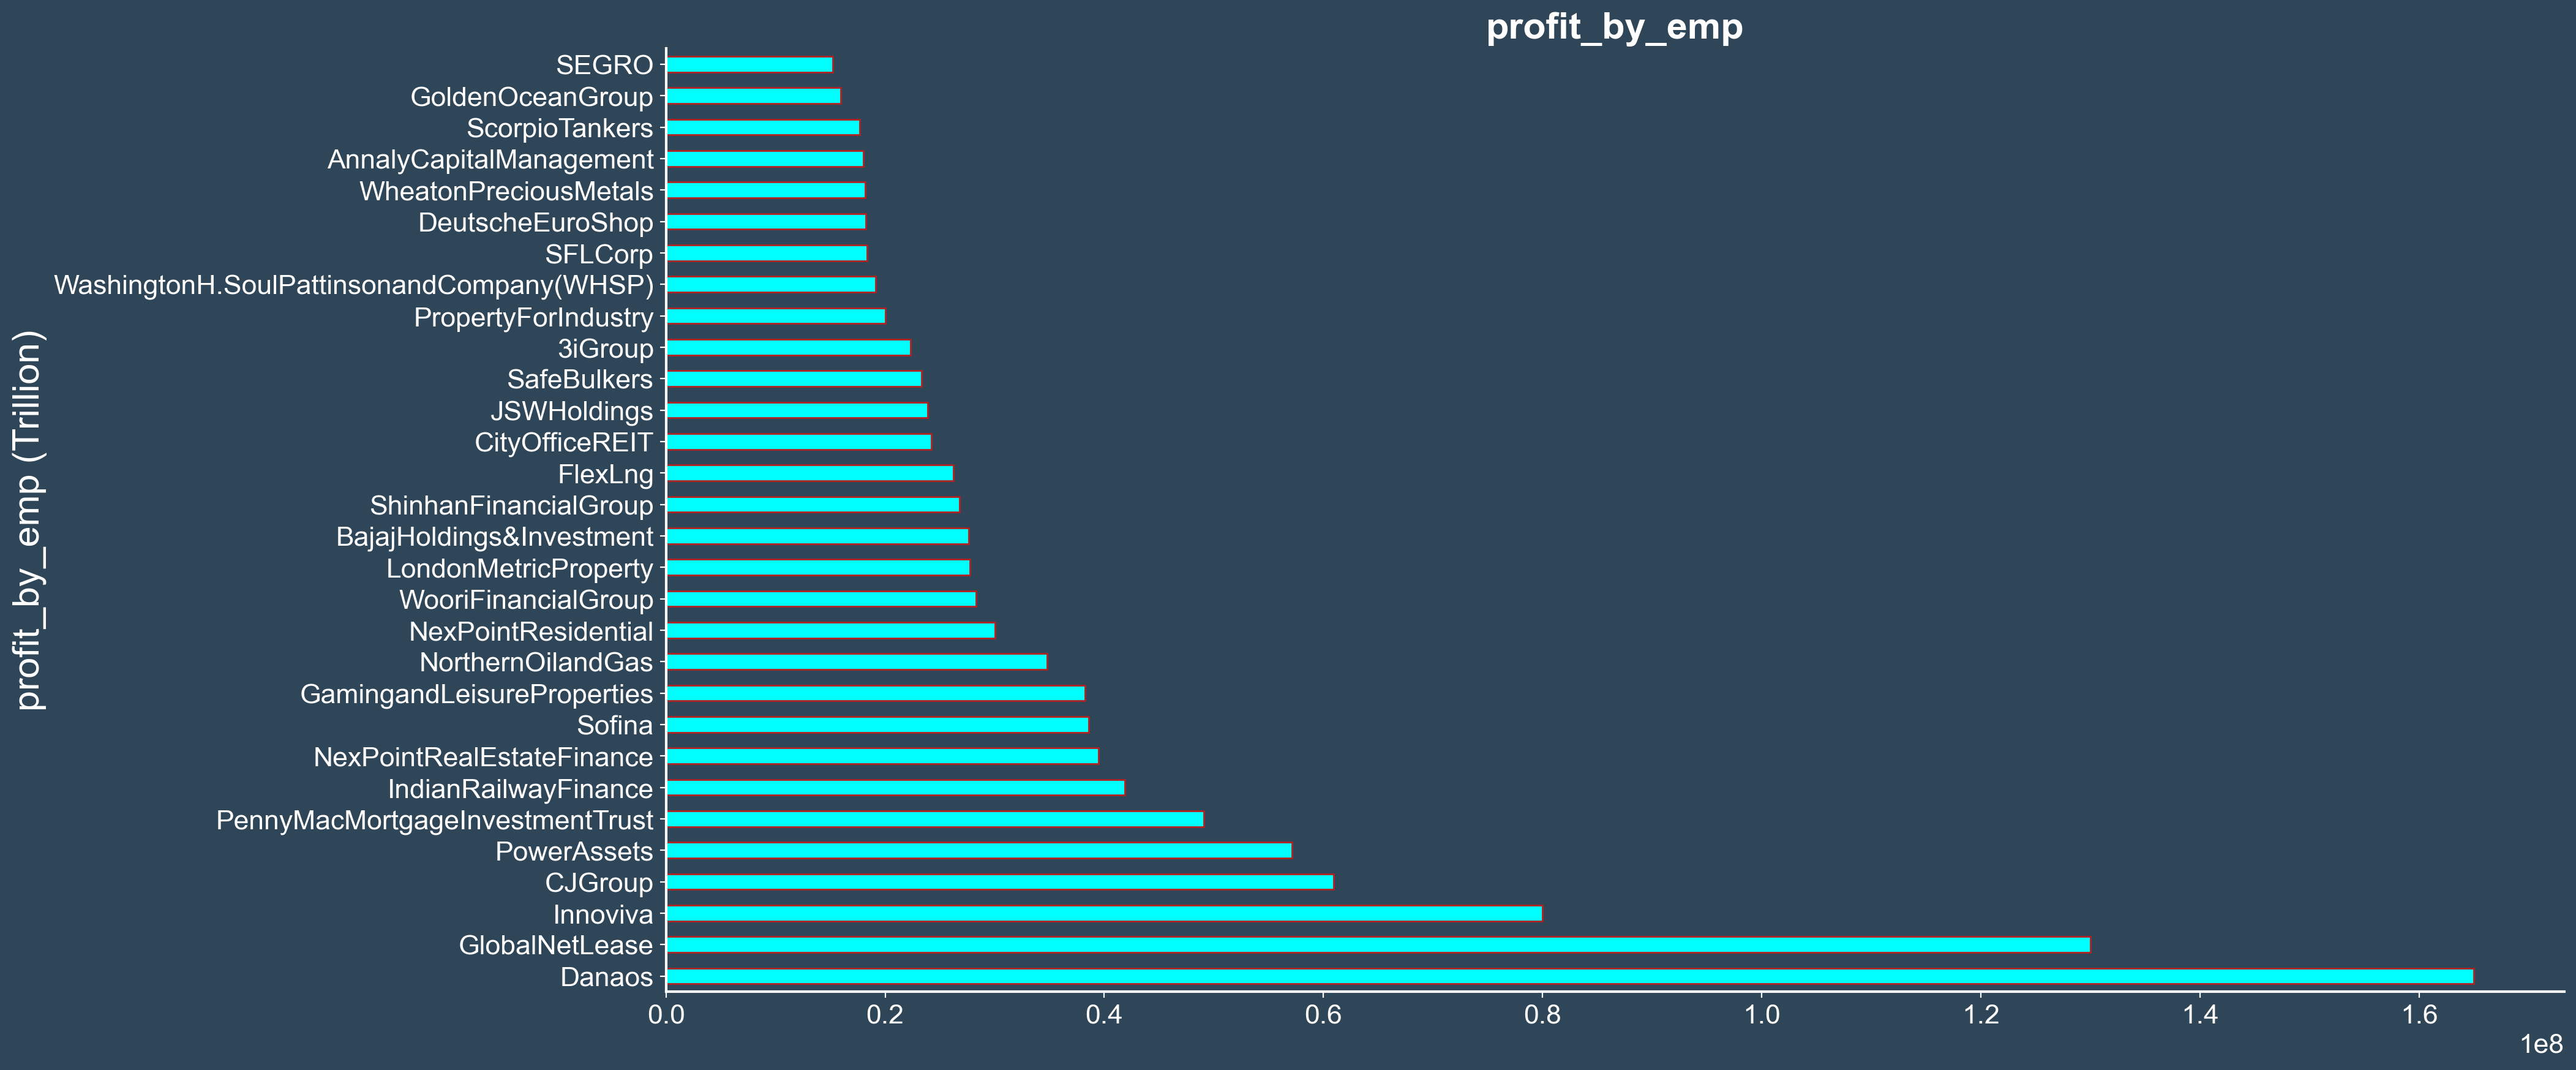

In [56]:
fig, ax = plt.subplots(figsize=(20, 10), facecolor=facecolor)
df_profit_by_emp.head(30).plot(kind="barh", color="cyan", edgecolor="firebrick", ax=ax)
ax.set_title("profit_by_emp")
ax.set(ylabel="profit_by_emp (Trillion)")

# scale_y = 1e12
# ticks_y = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / scale_y))
# ax.yaxis.set_major_formatter(ticks_y)

ax.tick_params(axis="x", labelrotation=0)
ax.get_legend().remove()

In [58]:
df_profit_by_emp.head(30)

profit_by_emp
company                                                 
Danaos                                      1.650000e+08
GlobalNetLease                              1.300000e+08
Innoviva                                    8.000000e+07
CJGroup                                     6.090909e+07
PowerAssets                                 5.714286e+07
PennyMacMortgageInvestmentTrust             4.906000e+07
IndianRailwayFinance                        4.189189e+07
NexPointRealEstateFinance                   3.945000e+07
Sofina                                      3.855263e+07
GamingandLeisureProperties                  3.823529e+07
NorthernOilandGas                           3.480000e+07
NexPointResidential                         3.003000e+07
WooriFinancialGroup                         2.829060e+07
LondonMetricProperty                        2.771429e+07
BajajHoldings&Investment                    2.761905e+07
ShinhanFinancialGroup                       2.677249e+07
FlexLng                                     2.625000e+07
CityOfficeREIT                              2.421053e+07
JSWHoldings                                 2.389000e+07
SafeBulkers                                 2.333333e+07
3iGroup                                     2.233051e+07
PropertyForIndustry                         2.000000e+07
WashingtonH.SoulPattinsonandCompany(WHSP)   1.914894e+07
SFLCorp                                     1.833333e+07
DeutscheEuroShop                            1.822400e+07
WheatonPreciousMetals                       1.818182e+07
AnnalyCapitalManagement                     1.801170e+07
ScorpioTankers                              1.769231e+07
GoldenOceanGroup                            1.594595e+07
SEGRO                                       1.524675e+07